# `nnsim.jl` Tour
This notebook serves as a tutorial or tour of sorts of `nnsim`, a Julia package intended for forward simulation of neural networks (NNs). 

`nnsim` provides the general structure of a neural network topology from neurons to layers and full networks. The dynamics of neurons are specified by the user in the form of update mathematical update rules. Given a mathematical description of the neuron, `nnsim` then stacks these neurons into layers and networks which can be used for simulation or inference. 

In principle, both artificial and spiking NNs are supported. 

In [2]:
# using Revise # Used for development
using Parameters
using nnsim
using PyPlot

## Neurons
The fundamental building block of a NN is the neuron. `nnsim` includes an `AbstractNeuron` type to be implemented by the user for their specified type. The full implementation of an _Izhikevich_ neuron is contained in the cell below.

For now, the only functions necessary for implementing a neural network are:
1. `update!` which implements the update rule for the neuron, including a concept of time
2. `reset!` which resets the neuron to its default state

It is important that any state variables in the type be stored within an `Array` under the name `state`, or otherwise the struct must be declared mutable. Code for tracking the internal states of the neurons requires the state(s) to be tracked be stored in a parameter named `state`.

In [3]:
@with_kw struct Izh{F}<:AbstractNeuron
   a::F = 0.02      # a-d are model parameters
   b::F = 0.2
   c::F = -65.
   d::F = 8.
   I::F = 25.       # Background current injection (mA)
   θ::F = 30.       # Threshold potential (mV)

   v0::F = -65.     # Reset voltage (mV)
   u0::F = 0.       # Reset state variable
   state::Array{F,1} = [-65., 0.]      # Membrane potential (mV) and state variable
end

Izh

In [5]:
function nnsim.update!(neuron::Izh, input_update, dt, t)
    retval = 0
    # If an impulse came in, add it
    neuron.state[1] += input_update
    
    neuron.state[1] += dt*(0.04 * neuron.state[1]^2 + 5*neuron.state[1] + 140 - neuron.state[2] + neuron.I)
    neuron.state[2] += dt*(neuron.a)*(neuron.b*neuron.state[1]-neuron.state[2])
    
    # Check for thresholding
    if neuron.state[1] >= neuron.θ
        neuron.state[1] = neuron.v0
        neuron.state[2] = neuron.state[2] + neuron.d
        retval = 1
    end

    return retval
end

function nnsim.reset!(neuron::Izh)
    neuron.state .= [neuron.v0, neuron.u0]
end

## Layers
We're now ready to build layers and a full network out of these neurons!

A layer is a collection of neurons with input weights. For this reason, we need to specify both the input weights as well as the neurons that make up our layer. 

Let's construct two layers of eight homogeneous Izhikevich neurons each, all with the default parameters. 

In [6]:
N = 4

W1 = randn(N,2) # Random NxN matrix
W1 = W1./maximum(abs.(W1)) # Normalize
L1 = batch_layer_construction(Izh, W1, N) # Layer 1

W2 = randn(N,N) 
L2 = batch_layer_construction(Izh, W2, N); # Layer 2

## Networks
We can supply the list of layers to construct a network. Then we simulate the network with constant inputs of `[0., -.002]` for 240 seconds with 1 millisecond time steps.

On the development machine this simulation executes in about 1.6 seconds.

In [7]:
net = Network([L1, L2]);

In [8]:
dt = 0.001
tf = 240.
t0 = 0.

reset!(net)
@time outputs, states = simulate!(net, [0., -0.02], dt, tf, track_flag = true);

  2.075064 seconds (17.84 M allocations: 727.961 MiB, 25.60% gc time)


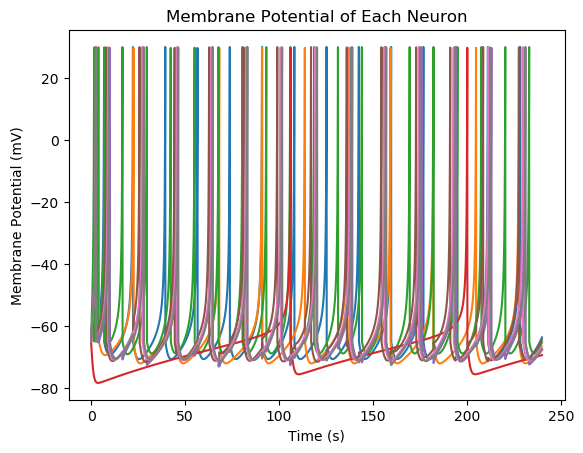

In [9]:
# Plot membrane potentials, skip the recovery variable
plot(t0:dt:tf, transpose(states[1:2:end,2:end]))
xlabel("Time (s)")
ylabel("Membrane Potential (mV)")
title("Membrane Potential of Each Neuron");

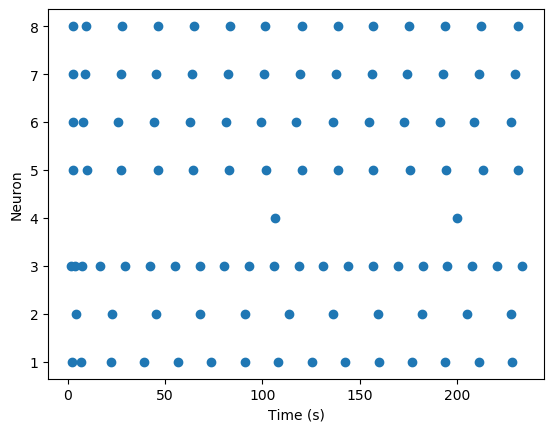

In [10]:
# Spiking event plot for network
xs = []
ys = []
for pt in findall(outputs.>0)
    push!(xs, pt[2]*dt)
    push!(ys, pt[1])
end
scatter(xs, ys)
xlabel("Time (s)")
ylabel("Neuron");

## Benchmarking and Miscellaneous

In [12]:
function f()
    update!(net.layers[1], [0., -0.02], 0.001, 99)
    @time update!(net.layers[1], [0., -0.02], 0.001, 99)
    update!(net.layers[1], 0, 0.001, 99)
    @time update!(net.layers[1], 0, 0.001, 99)
end
f();

  0.000002 seconds (5 allocations: 288 bytes)
  0.000001 seconds
